##### Load Modules:

In [1]:
import pandas as pd
import numpy as np
import pickle
import random
import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
import matplotlib.font_manager
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns

##### Settings:

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

pd.options.display.float_format = '{:.2f}'.format

FIGSIZE = (15, 20)

In [3]:
train = pd.read_csv('course_project_train.csv')
test = pd.read_csv('course_project_test.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [5]:
print(f'Training data shape: {train.shape}')
train.head()

Training data shape: (7500, 17)


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.00,NaN,0.00,11.00,26.30,685960.00,1.00,nan,1.00,debt consolidation,Short Term,99999999.00,47386.00,7914.00,749.00,0
1,Own Home,1025487.00,10+ years,0.00,15.00,15.30,1181730.00,0.00,nan,0.00,debt consolidation,Long Term,264968.00,394972.00,18373.00,737.00,1
2,Home Mortgage,751412.00,8 years,0.00,11.00,35.00,1182434.00,0.00,nan,0.00,debt consolidation,Short Term,99999999.00,308389.00,13651.00,742.00,0
3,Own Home,805068.00,6 years,0.00,8.00,22.50,147400.00,1.00,nan,1.00,debt consolidation,Short Term,121396.00,95855.00,11338.00,694.00,0
4,Rent,776264.00,8 years,0.00,13.00,13.60,385836.00,1.00,nan,0.00,debt consolidation,Short Term,125840.00,93309.00,7180.00,719.00,0


In [6]:
print(f'Testing data shape: {test.shape}')
test.head()

Testing data shape: (2500, 16)


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,nan,4 years,0.00,9.00,12.50,220968.00,0.00,70.00,0.00,debt consolidation,Short Term,162470.00,105906.00,6813.00,nan
1,Rent,231838.00,1 year,0.00,6.00,32.70,55946.00,0.00,8.00,0.00,educational expenses,Short Term,78298.00,46037.00,2318.00,699.00
2,Home Mortgage,1152540.00,3 years,0.00,10.00,13.70,204600.00,0.00,nan,0.00,debt consolidation,Short Term,200178.00,146490.00,18729.00,7260.00
3,Home Mortgage,1220313.00,10+ years,0.00,16.00,17.00,456302.00,0.00,70.00,0.00,debt consolidation,Short Term,217382.00,213199.00,27559.00,739.00
4,Home Mortgage,2340952.00,6 years,0.00,11.00,23.60,1207272.00,0.00,nan,0.00,debt consolidation,Long Term,777634.00,425391.00,42605.00,706.00


##### Анализ целевой переменной:

In [7]:
target = 'Credit Default'
base_feature_names = train.columns.drop(target).tolist()
new_feature_names= train.columns.drop([target] + base_feature_names)

In [8]:
train[target].value_counts()


0    5387
1    2113
Name: Credit Default, dtype: int64

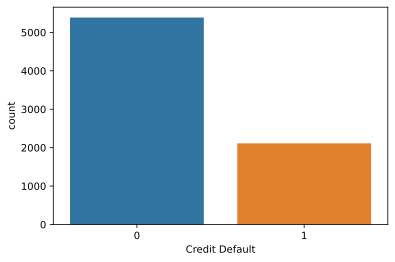

In [9]:
sns.countplot(x=target, data=train)

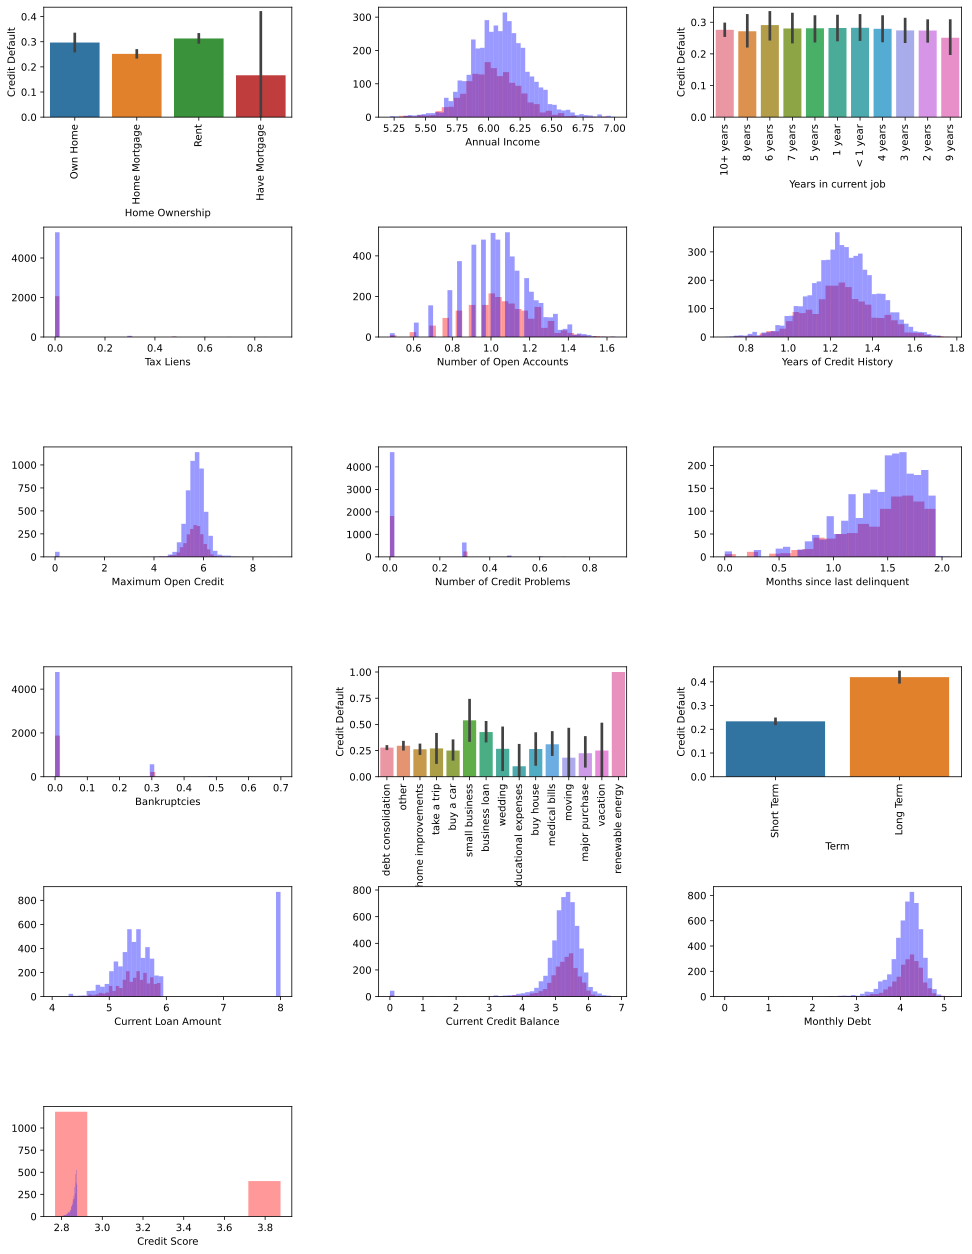

In [10]:
cat_list = list(train.loc[:, ~train.columns.isin(['Id', 'Credit Default'])])

ncols = 3
nrows = math.ceil(len(cat_list) / ncols)
index = 1

default_col = 'red'
nodefault_col = 'blue'

fig,ax = plt.subplots(figsize=FIGSIZE, ncols=1)

for col_name in cat_list:
    plt.subplot(nrows, ncols, index)
    index += 1
    
    if train[col_name].dtypes.kind == 'O':
        g = sns.barplot(x=col_name, y=target, data=train)
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
    else:
        sns.distplot(np.log10(train[train[target] == 1][col_name].dropna().values+1), kde=False, color=default_col)
        sns.distplot(np.log10(train[train[target] == 0][col_name].dropna().values+1), kde=False, color=nodefault_col, axlabel=col_name)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=1, wspace=0.35)
ax.autoscale(enable=True) 
plt.show()

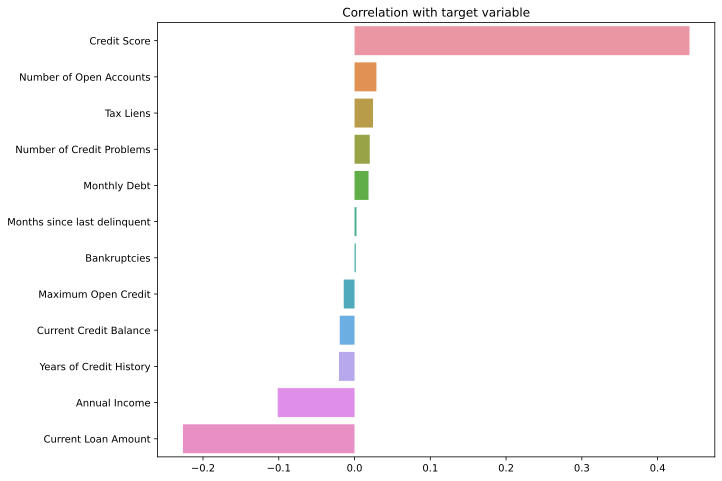

In [11]:
corr_with_target = train[base_feature_names + [target]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

##### Correlations:

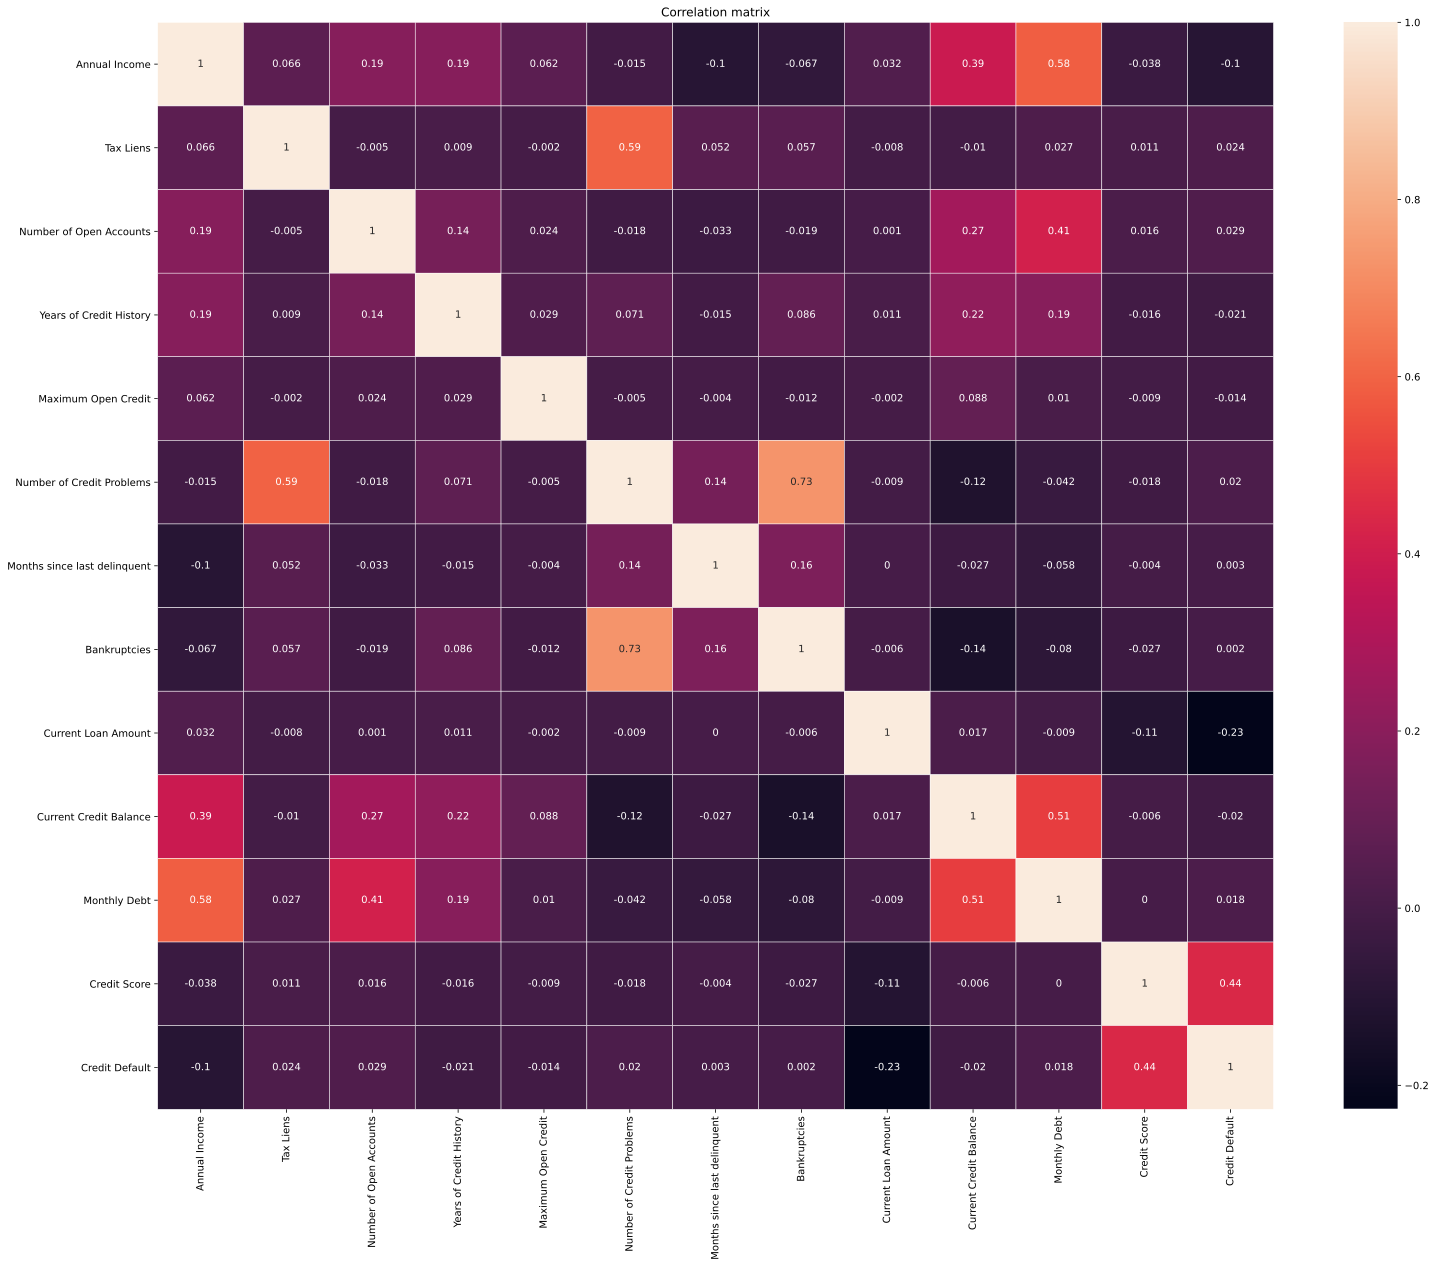

In [12]:
plt.figure(figsize = (25,20))

sns.heatmap(train[base_feature_names + [target]].corr().round(3), annot=True, linewidths=.5)

plt.title('Correlation matrix')
plt.show()

##### Missing values:



In [13]:
class FeatureImputer:
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        X['Purpose_1'] = X['Purpose'].isin(['medical bills']) * 1
        X['Purpose_2'] = X['Purpose'].isin(['buy a car']) * 1
        X['Purpose_3'] = X['Purpose'].isin(['home improvements']) * 1
        X['Purpose_4'] = X['Purpose'].isin(['buy house']) * 1
        X['Purpose_5'] = X['Purpose'].isin(['major purchase']) * 1
        X['Purpose_6'] = X['Purpose'].isin(['other']) * 1
        X['Purpose_7'] = X['Purpose'].isin(['wedding']) * 1
        X['Purpose_8'] = X['Purpose'].isin(['small business']) * 1
        X['Purpose_9'] = X['Purpose'].isin(['renewable energy']) * 1
        X['Purpose_10'] = X['Purpose'].isin(['educational expenses']) * 1
        X['Purpose_11'] = X['Purpose'].isin(['business loan']) * 1
        X['Purpose_12'] = X['Purpose'].isin(['take a trip']) * 1
        X['Purpose_13'] = X['Purpose'].isin(['vacation']) * 1
        X['Purpose_14'] = X['Purpose'].isin(['moving']) * 1
        X['Purpose_15'] = X['Purpose'].isin(['debt consolidation']) * 1
        
        X['Home_1'] = X['Home Ownership'].isin(['Home Mortgage'])*1
        X['Home_2'] = X['Home Ownership'].isin(['Have Mortgage'])*1
        X['Home_3'] = X['Home Ownership'].isin(['Rent'])*1
        X['Home_4'] = X['Home Ownership'].isin(['Own Home'])*1
        
        X['Term_val'] = X['Term'].isin(['Long Term'])*1

        
        X.loc[X['Years in current job'] == '9 years', 'Years in current job'] = 9
        X.loc[X['Years in current job'] == '7 years', 'Years in current job'] = 7
        X.loc[X['Years in current job'] == '6 years', 'Years in current job'] = 6
        X.loc[X['Years in current job'] == '4 years', 'Years in current job'] = 4
        X.loc[X['Years in current job'] == '8 years', 'Years in current job'] = 8
        X.loc[X['Years in current job'] == '1 year', 'Years in current job'] = 1
        X.loc[X['Years in current job'] == '5 years', 'Years in current job'] = 5
        X.loc[X['Years in current job'] == '10+ years', 'Years in current job'] = 10
        X.loc[X['Years in current job'] == '3 years', 'Years in current job'] = 3
        X.loc[X['Years in current job'] == '2 years', 'Years in current job'] = 2
        X.loc[X['Years in current job'] == '< 1 year', 'Years in current job'] = 0.5
        X['Years in current job'] = X['Years in current job'].apply(pd.to_numeric, errors='coerce')
        X.loc[X['Years in current job'].isna()*1 == 1, 'Years in current job'] = self.medians['Years in current job']
        
        X.loc[X['Credit Score'].isna(), 'Credit Score'] = self.medians['Credit Score']

        
        X.loc[X['Annual Income'].isna(), 'Annual Income'] = self.medians['Annual Income']
        
        X.loc[X['Bankruptcies'].isna(), 'Bankruptcies'] = self.medians['Bankruptcies']
        
        X.loc[X['Current Loan Amount'] > 1000000, 'Current Loan Amount'] = self.medians['Current Loan Amount']
        
        X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent'] = 0

        return X

In [14]:
X = []

In [16]:
imputer = FeatureImputer()

imputer.fit(train)
X = imputer.transform(train)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [18]:
num_feature_names = ['Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 
                         'Number of Credit Problems', 'Years of Credit History',
                        'Maximum Open Credit', 'Current Loan Amount', 'Months since last delinquent',
                         'Current Credit Balance', 'Bankruptcies','Monthly Debt', 'Credit Score']
bin_feature_names = ['Purpose_1', 'Purpose_2', 'Purpose_3', 'Purpose_4', 'Purpose_5', 'Purpose_6', 'Purpose_7', 'Purpose_8',
                    'Purpose_9', 'Purpose_10', 'Purpose_11', 'Purpose_12', 'Purpose_13', 'Purpose_14', 'Purpose_15', 
                     'Home_1', 'Home_2', 'Home_3', 'Home_4', 'Term_val']

##### Splitting the train sample:

In [19]:
X_t = X[num_feature_names + bin_feature_names]
y_t = X[target]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, shuffle=True, test_size=0.30, random_state=21)

##### Modelling:

In [21]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [22]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [23]:
result_model_score = {}


##### CatBoost: 

In [24]:
params = {
    'class_weights':[1, 2.3],
    'n_estimators': 420,
    'max_depth': 3,
    'silent':True,
    'random_state':50,
    'eval_metric':'F1',
    'early_stopping_rounds':20,
    'l2_leaf_reg':10
}

In [25]:
model_catb = catb.CatBoostClassifier(**params)

model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)


get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      3771
           1       0.58      0.64      0.61      1479

    accuracy                           0.77      5250
   macro avg       0.71      0.73      0.72      5250
weighted avg       0.78      0.77      0.77      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.79      0.81      1616
           1       0.51      0.56      0.54       634

    accuracy                           0.73      2250
   macro avg       0.67      0.68      0.67      2250
weighted avg       0.74      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1277  339
1                276  358


In [26]:
model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_catb
model_score['model_name'] = 'model_catb'
result_model_score['CatBoost'] = model_score

##### Ada Boost:

In [27]:
from sklearn.ensemble import AdaBoostClassifier

model_ada = AdaBoostClassifier(
    n_estimators=400,
    learning_rate=0.86,
    algorithm='SAMME.R',
)
model_ada.fit(X_train, y_train)

y_train_pred = model_ada.predict(X_train)
y_test_pred = model_ada.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_ada
model_score['model_name'] = 'model_ada'
result_model_score['Ada Boost'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.97      0.88      3771
           1       0.82      0.39      0.53      1479

    accuracy                           0.80      5250
   macro avg       0.81      0.68      0.70      5250
weighted avg       0.81      0.80      0.78      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.94      0.85      1616
           1       0.68      0.31      0.43       634

    accuracy                           0.76      2250
   macro avg       0.73      0.63      0.64      2250
weighted avg       0.75      0.76      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1521   95
1                436  198


##### Logistic Regression:

In [28]:
model_lr = LogisticRegression(
    solver='liblinear', 
    penalty='l2',
    max_iter=160,
    class_weight='balanced',
    C=2,
)
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_lr
model_score['model_name'] = 'model_lr'

result_model_score['Logistic Regression'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.64      0.71      3771
           1       0.40      0.62      0.49      1479

    accuracy                           0.63      5250
   macro avg       0.61      0.63      0.60      5250
weighted avg       0.70      0.63      0.65      5250

TEST

              precision    recall  f1-score   support

           0       0.80      0.62      0.70      1616
           1       0.38      0.60      0.47       634

    accuracy                           0.62      2250
   macro avg       0.59      0.61      0.58      2250
weighted avg       0.68      0.62      0.63      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1006  610
1                255  379


##### K Nearest Neighbours:

In [29]:
model_knn = KNeighborsClassifier(
    weights='uniform',
    p=1,
    n_neighbors=1,
    leaf_size=19,
    algorithm='ball_tree',
    n_jobs=-1,
)
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_knn
model_score['model_name'] = 'model_knn'
result_model_score['K Nearest Neighbours'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3771
           1       1.00      1.00      1.00      1479

    accuracy                           1.00      5250
   macro avg       1.00      1.00      1.00      5250
weighted avg       1.00      1.00      1.00      5250

TEST

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1616
           1       0.34      0.34      0.34       634

    accuracy                           0.63      2250
   macro avg       0.54      0.54      0.54      2250
weighted avg       0.63      0.63      0.63      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1200  416
1                417  217


##### LightGBM:

In [30]:
model_lgbm = lgbm.LGBMClassifier(
    subsample=0.4,
    reg_lambda=0.0,
    reg_alpha=0.75,
    num_leaves=40,
    n_estimators=250,
    min_child_weight=0.05,
    max_depth=3,
    learning_rate=0.86,
    is_unbalance=True,
    boosting_type='gbdt',
    n_jobs=-1,
    random_state=21
)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['name'] = 'LightGBM'
model_score['model'] = model_lgbm
model_score['model_name'] = 'model_lgbm'
result_model_score['LightGBM'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3771
           1       0.92      0.99      0.96      1479

    accuracy                           0.97      5250
   macro avg       0.96      0.98      0.97      5250
weighted avg       0.98      0.97      0.97      5250

TEST

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1616
           1       0.48      0.52      0.50       634

    accuracy                           0.70      2250
   macro avg       0.64      0.65      0.64      2250
weighted avg       0.71      0.70      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1259  357
1                307  327


##### Naive Bayes:

In [31]:
from sklearn.naive_bayes import GaussianNB

model_bay = GaussianNB()
model_bay = model_bay.fit(X_train, y_train)

y_train_pred = model_bay.predict(X_train)
y_test_pred = model_bay.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_bay
model_score['model_name'] = 'model_bay'
result_model_score['Naive Bayes'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.12      0.21      3771
           1       0.30      0.95      0.45      1479

    accuracy                           0.35      5250
   macro avg       0.57      0.53      0.33      5250
weighted avg       0.70      0.35      0.28      5250

TEST

              precision    recall  f1-score   support

           0       0.87      0.12      0.22      1616
           1       0.30      0.95      0.45       634

    accuracy                           0.36      2250
   macro avg       0.58      0.54      0.34      2250
weighted avg       0.71      0.36      0.28      2250

CONFUSION MATRIX

col_0             0     1
Credit Default           
0               200  1416
1                31   603


In [32]:
y_test_pred_probs = model_catb.predict_proba(X_test)

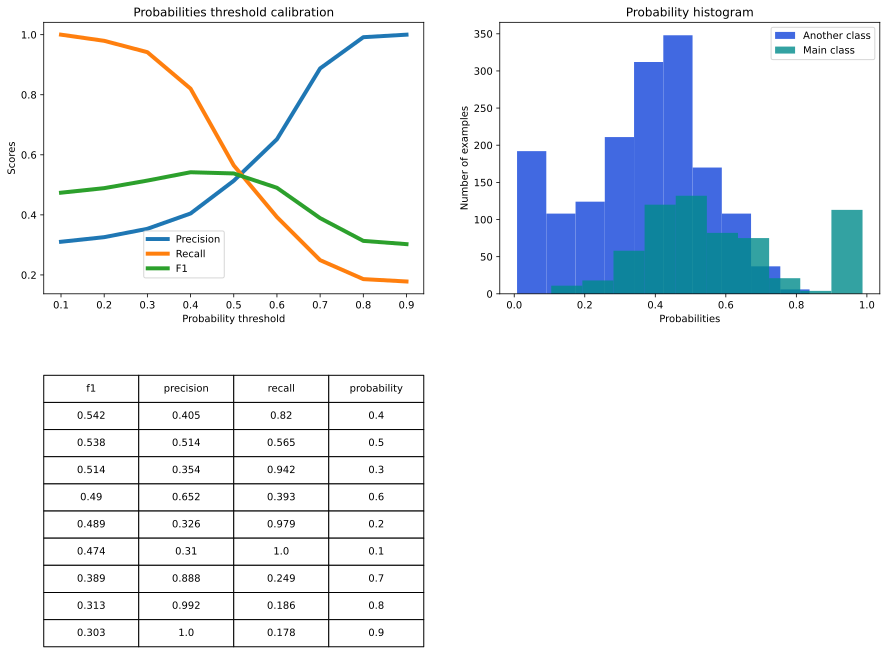

In [33]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)


In [34]:
X_test = pd.read_csv('course_project_test.csv')
X_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,nan,4 years,0.00,9.00,12.50,220968.00,0.00,70.00,0.00,debt consolidation,Short Term,162470.00,105906.00,6813.00,nan
1,Rent,231838.00,1 year,0.00,6.00,32.70,55946.00,0.00,8.00,0.00,educational expenses,Short Term,78298.00,46037.00,2318.00,699.00
2,Home Mortgage,1152540.00,3 years,0.00,10.00,13.70,204600.00,0.00,nan,0.00,debt consolidation,Short Term,200178.00,146490.00,18729.00,7260.00
3,Home Mortgage,1220313.00,10+ years,0.00,16.00,17.00,456302.00,0.00,70.00,0.00,debt consolidation,Short Term,217382.00,213199.00,27559.00,739.00
4,Home Mortgage,2340952.00,6 years,0.00,11.00,23.60,1207272.00,0.00,nan,0.00,debt consolidation,Long Term,777634.00,425391.00,42605.00,706.00


In [35]:
X_test.describe()


,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1987.00,2500.00,2500.00,2500.00,2500.00,2500.00,1142.00,2497.00,2500.00,2500.00,2500.00,1987.00
mean,1366921.68,0.04,11.18,18.33,710570.41,0.16,34.18,0.11,12155719.63,296396.65,18271.34,1234.52
std,917125.15,0.39,4.85,7.25,1511983.48,0.56,22.02,0.36,32260973.72,378301.97,11543.88,1740.22
min,106533.00,0.00,1.00,3.90,0.00,0.00,0.00,0.00,15422.00,0.00,93.00,585.00
25%,852311.50,0.00,8.00,13.40,278586.00,0.00,16.00,0.00,187126.50,110114.50,10024.75,710.00
50%,1178475.00,0.00,10.00,17.00,478676.00,0.00,30.00,0.00,322366.00,207385.00,16642.50,731.00
75%,1629734.50,0.00,14.00,22.10,802598.50,0.00,50.00,0.00,522582.50,366348.50,24146.00,743.00
max,14975610.00,15.00,48.00,53.40,54484386.00,15.00,82.00,5.00,99999999.00,6030087.00,93555.00,7480.00


In [36]:
imputer = FeatureImputer()

imputer.fit(X_test)
X_test = imputer.transform(X_test)

KeyError: 'Years in current job'

In [ ]:
X_test = X_test[num_feature_names + bin_feature_names]


In [45]:
y_test_pred = model_catb.predict(X_test)


CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="Rent": Cannot convert 'b'Rent'' to float

In [46]:
y_test_pred = pd.DataFrame(y_test_pred, columns=['Credit Default'])
y_test_pred

,Credit Default
0,1
1,0
2,0
3,1
4,1
...,...
2245,1
2246,0
2247,1
2248,1


In [60]:
check = y_test_pred.to_csv('Belyaeva_Alex.csv', index=False)

In [61]:
check